In [ ]:
# Set environment
# colab_env = 1 --> Google colab
# colab_env = 0 --> Local
colab_env = 1

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import shutil
import glob
home_dir = os.path.expanduser("~")
content_dir = '/content'
print('Home path is'+home_dir)

Home path is/root


Data preparation

In [2]:
# Kaggle API token

! pip install -q kaggle
from google.colab import files
if os.path.isfile('./kaggle.json') == False:
    files.upload()
print('Kaggle credential uploaded')

Saving kaggle.json to kaggle.json
Kaggle credential uploaded


In [4]:
data_path = content_dir +'/data'
print('Data is stored at: '+data_path)
os.makedirs(content_dir+'/.kaggle',exist_ok = True)
os.system('cp kaggle.json '+str(home_dir) +'/.kaggle/')
os.system('chmod 600 '+str(home_dir)+'/.kaggle/kaggle.json')
os.system('kaggle competitions download -c mais202fall2021 -p '+data_path)
fname_zip = glob.glob(data_path+'/'+'*.zip'); print(fname_zip)
for i in range(len(fname_zip)):
    shutil.unpack_archive(fname_zip[i], './data')

Data is stored at: /content/data
['/content/data/train_images.npy.zip', '/content/data/test_images.npy.zip']


In [ ]:
# show_image function 

import matplotlib.pyplot as plt

def show_image(arr):
    two_d = (np.reshape(arr, (28, 28)) * 255).astype(np.uint8)
    plt.imshow(two_d,cmap="Greys")
    plt.show()


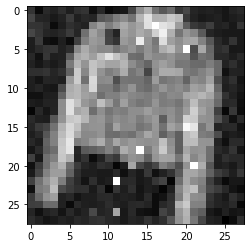

(50000, 28, 28)
(20000, 28, 28)
(50000, 1)


In [ ]:
x_train = np.load(data_path+'/train_images.npy')
x_test = np.load(data_path+'/test_images.npy')

y_train = pd.read_csv(data_path+'/train_labels.csv', index_col=0)
y_train = pd.DataFrame(y_train).to_numpy()

show_image(x_train[1])

# print(y_train)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)

Approach 1

In [ ]:
from tensorflow.keras.utils import to_categorical

def load_and_preprocess_data():
    
    # split into cross-val & test sets (8000 records in cross-val & 2000 in test set)    
    val_count = 8000
    x_val = x_test[:val_count]
    y_val = y_test[:val_count]
    x_test = x_test[val_count:]
    y_test = y_test[val_count:]

    # keep an non pre-processed copy of X_test/y_test for visualization
    test_images, test_labels = x_test.copy(), y_test.copy()
    epsilon = 1e-7  # to avoid divide by small numbers
    x_train_mean = np.mean(x_train, axis=(0,1,2,3))
    x_train_std = np.std(x_train, axis=(0,1,2,3))
    x_train = (x_train - x_train_mean) / (x_train_std + epsilon)
    x_val = (x_val - x_train_mean) / (x_train_std + epsilon)
    x_test = (x_test - x_train_mean) / (x_train_std + epsilon)
    
    # one-hot encode labels to 10 output classes corresponding to digits 0-9
    y_train = to_categorical(y_train, 10)
    y_val = to_categorical(y_val, 10)
    y_test = to_categorical(y_test, 10)

    # reshape the image arrays (make 2D arrays instead of 3D arrays)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
    x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], x_val.shape[2], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

    return (x_train, y_train), (x_val, y_val), (x_test, y_test), (test_images, test_labels)

In [ ]:
import keras.backend as K
from keras.layers import (Input, Dense, Dropout, Conv2D, MaxPooling2D, Activation, BatchNormalization, Flatten)
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
K.clear_session()

In [ ]:
def train_and_evaluate_model(model, x_train, y_train, x_val, y_val, 
                            num_epochs=25, batch_size=32, callbacks=None):

    callbacks_list_default = [
        # reduce learning rate by a factor of 5 (i.e. lr/=5.0) 
        # if val_loss does not reduce for 3 epochs
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3
        ),
        # Stop training if val_acc does not improve for
        # 5 or more epochs
        EarlyStopping(
            monitor='val_acc',
            patience=5        
        )
    ]
    callbacks2use = (callbacks_list_default if callbacks is None else callbacks)

    history = model.fit(x_train, y_train, epochs=num_epochs,
                            batch_size = batch_size, validation_data = (x_val, y_val), 
                            callbacks = callbacks2use)
    
    loss, acc = model.evaluate(X_train, y_train, verbose=1)
    print("  Training : loss %.3f - acc %.3f" % (loss, acc))
    
    print('Cross-validation data:', flush=True)
    loss, acc = model.evaluate(X_val, y_val, verbose=1)
    print("  Cross-val: loss %.3f - acc %.3f" % (loss, acc))
    